In [ ]:
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
import json

In [ ]:
import time
start_time = time.time()

In [ ]:
TRAIN_PATH = Path("/home/ubuntu/data-1/nybg2020/train/")

In [ ]:
! ls $TRAIN_PATH

In [ ]:
with open(TRAIN_PATH/"metadata.json", encoding="utf8", errors='ignore') as json_file:
    data = json.load(json_file)

In [ ]:
for i in data.keys():
    print(f'{i}: {len(data[i])}')

In [ ]:
df_ann =  pd.DataFrame.from_dict(data["annotations"])

In [ ]:
df_imgs =  pd.DataFrame.from_dict(data["images"])

In [ ]:
df_cat =  pd.DataFrame.from_dict(data["categories"])

In [ ]:
df_cat.head()

In [ ]:
df_merged = pd.merge(df_ann,df_imgs,on="id")
df_merged.to_csv("train_data.csv")
# df_merged = pd.merge(df_ann,df_imgs,left_on="image_id", right_on="id")

In [ ]:
df_merged = pd.merge(df_merged,df_cat, left_on="category_id", right_on="id")

In [ ]:
df_merged = df_merged.drop(columns=["id_x", "id_y"]) #get rid of repeated data

In [ ]:
# df_merged = df_merged.rename(columns={"category_id":"label", "file_name":"name", "name":"class_name"})

In [ ]:
 df_merged.head()

In [ ]:
family_ids_map = {n:i for i,n in enumerate(set(df_merged["family"]))}
family_ids = [family_ids_map[i] for i in list(df_merged["family"]) ]

In [ ]:
len(family_ids), len(df_merged)

In [ ]:
genus_ids_map = {n:i for i,n in enumerate(set(df_merged["genus"]))}
genus_ids = [genus_ids_map[i] for i in list(df_merged["genus"]) ]

In [ ]:
len(family_ids), len(df_merged)

In [ ]:
df_merged["family_id"] = family_ids
df_merged["genus_id"] = genus_ids

In [ ]:
df_merged.tail()

In [ ]:
# df_merged.to_csv(TRAIN_PATH/"train.csv")

In [ ]:
# df_merged["genus"].value_counts()

In [ ]:
# df_merged["family"].value_counts()

Look at one sample from each region
Might be an options to train region classifier that may help narrow down selecting which class it is
Triplet loss, maybe use look for whale tale for some ideas

In [ ]:
# sample = df_merged.sample(n=2000).drop_duplicates(['region_id'])
# f_names = list(sample["file_name"])

In [ ]:
# from PIL import Image

In [ ]:
# im0 = Image.open(TRAIN_PATH/f_names[0])
# im1 = Image.open(TRAIN_PATH/f_names[1])
# im2 = Image.open(TRAIN_PATH/f_names[2])
# im3 = Image.open(TRAIN_PATH/f_names[3])

In [ ]:
# f, axarr = plt.subplots(2,2)
# axarr[0,0].imshow(im0)
# axarr[0,1].imshow(im1)
# axarr[1,0].imshow(im2)
# axarr[1,1].imshow(im3)


In [ ]:
#plt.imshow(im1)

Game plan
- pretrain on identifying region ?
- look at techniquqes used in the whawle identification stuff
- possibly use simese network

In [26]:
from fastai.vision import *

In [27]:
TRAIN_PATH = Path("/home/ubuntu/data-1/nybg2020/train/")
df = pd.read_csv(TRAIN_PATH/"train.csv")
df_train = df[[ "file_name", "category_id"]]

In [28]:
# df_train = df_merged[["file_name", "family_id"]]

In [29]:
df_train.head()

,file_name,category_id
0,images/156/72/354106.jpg,15672
1,images/156/72/545181.jpg,15672
2,images/156/72/449419.jpg,15672
3,images/156/72/200223.jpg,15672
4,images/156/72/5327.jpg,15672


In [30]:
df_train = df_train.rename(columns={"category_id": "label", "file_name":" name"})

In [38]:
def sample_class(x):
    if len(x) < 10:
        return x.sample(n=10, replace=True) 
    return x

In [31]:
counts  = df_train.label.value_counts() # Get Class counts

labels_keep = counts.keys()[counts>9] # Get labels that have more then 9 exmaples

df_new_train = df_train[df_train.label.isin(labels_keep)] # Select those items from df

# Do a random sample from data frame of 20 items
new_df = df_new_train.groupby('label').apply(lambda x: x.sample(n=20, replace=True)).reset_index(drop = True)

In [39]:
new_df = df_train.groupby('label').apply(sample_class).reset_index(drop = True)

In [40]:
len(new_df)

1121381

In [41]:
# there is a better way to do this
def sample(df, n=4):   
    validation_set = {}
    bool_arr = []
    for i,row in df.iterrows():
        if validation_set.get(row["label"], 0) == n:
            bool_arr.append(False) 
        else:
            validation_set[row["label"]] = validation_set.get(row["label"], 0) + 1
            bool_arr.append(True) 

        
    return bool_arr

In [42]:
valid = sample(new_df, n=4)

In [43]:
new_df["is_valid"] = valid

In [49]:
new_df.tail()

,name,label,is_valid,new_labels
1121376,images/320/93/1010199.jpg,32093,False,32092
1121377,images/320/93/946506.jpg,32093,False,32092
1121378,images/320/93/35450.jpg,32093,False,32092
1121379,images/320/93/946506.jpg,32093,False,32092
1121380,images/320/93/1005548.jpg,32093,False,32092


In [45]:
classes = new_df["label"].unique()

In [53]:
len(classes)

32093

In [46]:
classes_map = {classes[i]:i for i in range(len(classes))}

In [54]:
classes_map[32092]

32091

In [55]:
new_labels = [classes_map[i] for i in new_df["label"]]

In [56]:
new_df["new_labels"] = new_labels

In [57]:
data = (ImageList.from_df(new_df,TRAIN_PATH)
        .split_from_df()
        .label_from_df(cols="new_labels")
        .transform(size=256)
        .databunch(bs=128))

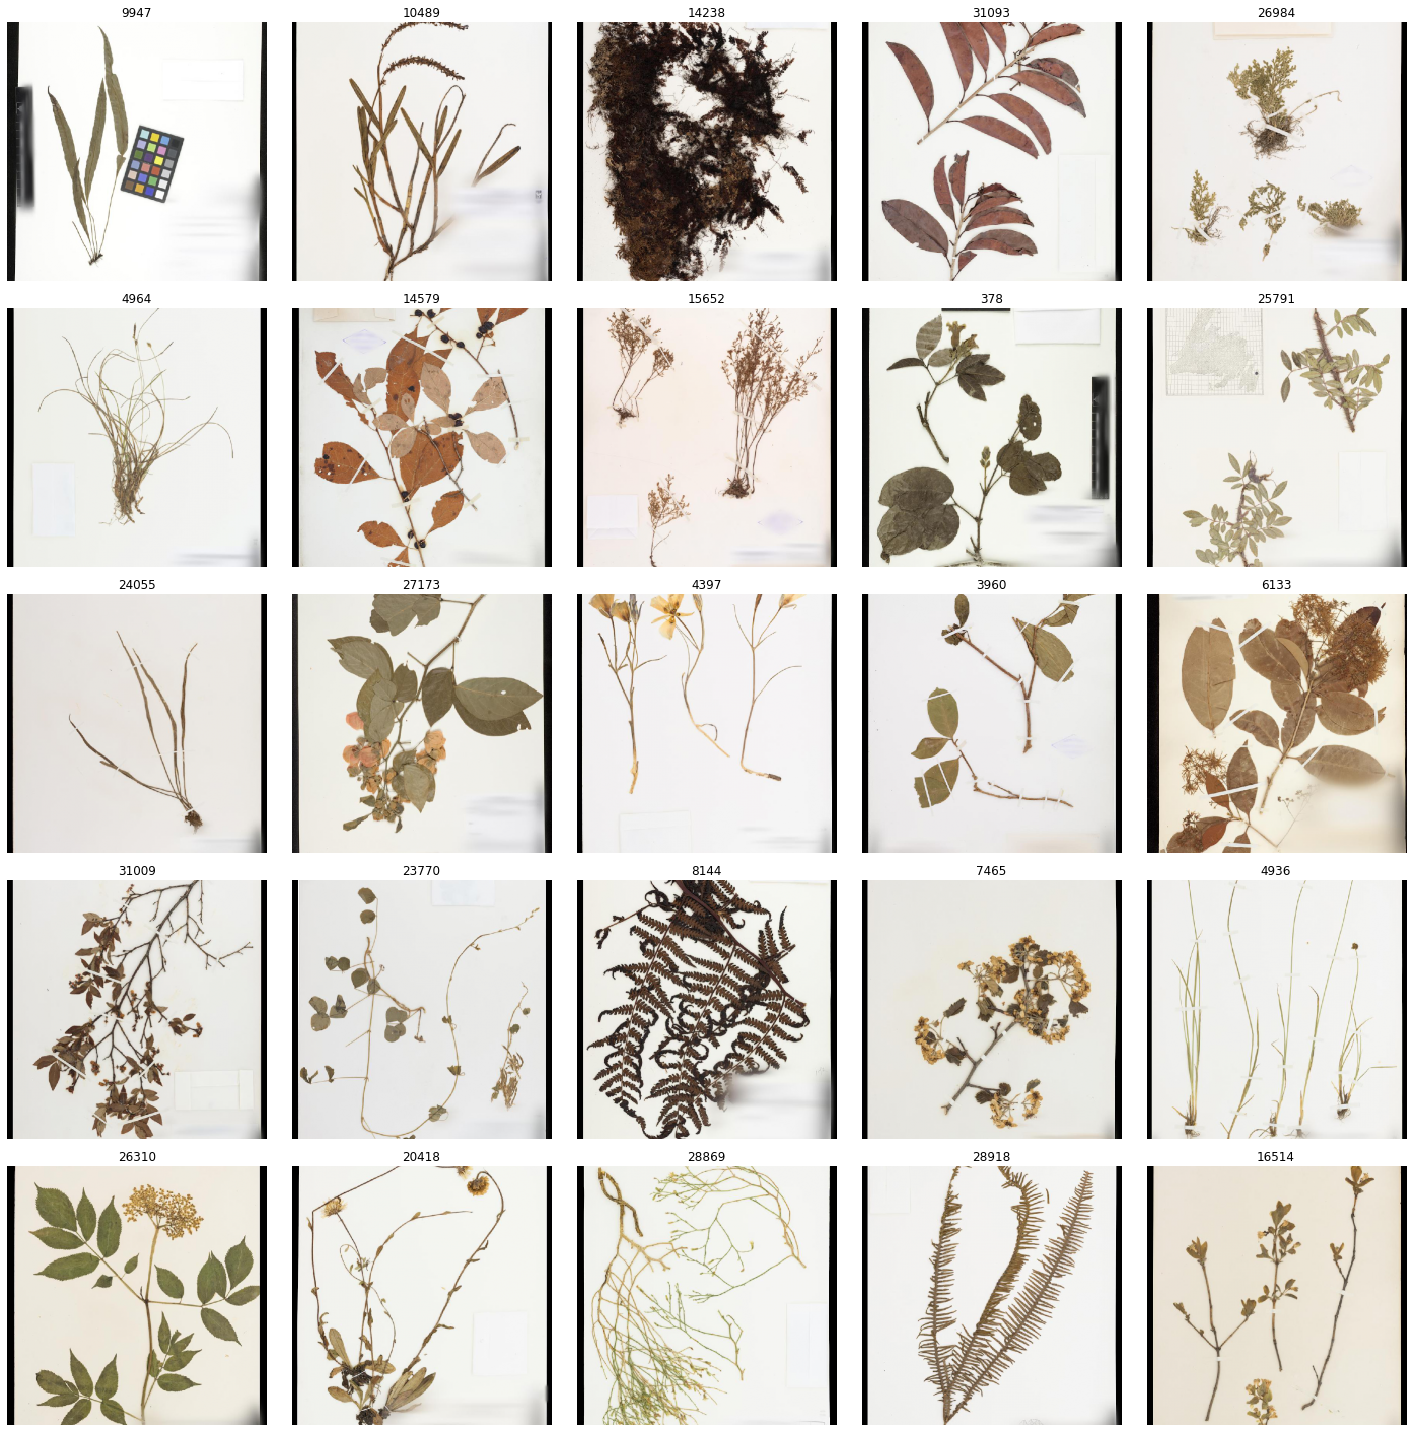

In [58]:
data.show_batch()

In [59]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy).to_fp16()

In [18]:
# learn.save("test",return_path=True)

PosixPath('/home/ubuntu/data-1/nybg2020/train/models/test.pth')

In [60]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,6.447951,10.831666,0.039946,5:17:09
1,6.084501,11.288708,0.061626,5:12:40
2,5.858338,11.841663,0.067297,5:12:55


In [61]:
learn.save("model-all-classes")

In [62]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(3, max_lr=(1e-4, 1e-3, 1e-2), wd=(1e-4,1e-4,1e-1))

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
learn.save("model-all-classes-unfreeze")

In [ ]:
learn.fit_one_cycle(3, max_lr=(1e-4, 1e-3, 1e-2), wd=(1e-4,1e-4,1e-1))

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
# learn.save("model-half-classes-unfreeze-2")

## Submission

In [ ]:
import json

In [ ]:
# get test data
TEST_PATH = Path("/home/ubuntu/data-1/nybg2020/test/")
with open(TEST_PATH/"metadata.json", encoding="utf8", errors='ignore') as json_file:
    data = json.load(json_file)
df_test =  pd.DataFrame.from_dict(data["images"])

In [ ]:
test_data = ImageImageList.from_df(df_test, TEST_PATH, cols="file_name")
learn.data.add_test(test_data)

In [ ]:
preds, y = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
res_flat = np.argmax(preds, axis=1)

In [ ]:
df_test["Predicted"] = res_flat

In [ ]:
sub = df_test[["id", "Predicted"]]

In [ ]:
subm_file = "/home/ubuntu/data-1/sub-2"

In [ ]:
sub.to_csv(subm_file, index=False)

In [ ]:
! kaggle competitions submit herbarium-2020-fgvc7 -f $subm_file -m "fastai sub"